In [2]:
import os
import json
import pandas as pd
import re
import folium
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from importlib.resources import files

In [3]:
unique_location_path = '../evrp/data/unique_locations.csv'
unique_location = pd.read_csv(unique_location_path)

In [4]:
velocity = pd.read_csv('../evrp/data/bookings_mapping.csv')
# filter out weekends
velocity['StartRequestedDate'] = pd.to_datetime(velocity['StartRequestedDate'], format='%d/%m/%Y')
velocity['EndRequestedDate'] = pd.to_datetime(velocity['EndRequestedDate'], format='%d/%m/%Y')
# Aggregate the number of bookings per day
bookings_per_day = velocity.groupby('StartRequestedDate').size().reset_index(name='NumberOfBookings').sort_values(by='NumberOfBookings', ascending=False)

# Categorize the number of bookings
def categorize_demand(bookings):
    if 10 <= bookings < 20:
        return 'Low demand'
    elif 20 <= bookings < 30:
        return 'Medium demand'
    elif bookings >= 30:
        return 'High demand'

bookings_per_day['DemandCategory'] = bookings_per_day['NumberOfBookings'].apply(categorize_demand)

# Count the number of instances for each category
demand_counts = bookings_per_day['DemandCategory'].value_counts().reset_index()
demand_counts.columns = ['DemandCategory', 'Instances']

# Save the dates that belong to each category
low_demand_dates = bookings_per_day[bookings_per_day['DemandCategory'] == 'Low demand']
medium_demand_dates = bookings_per_day[bookings_per_day['DemandCategory'] == 'Medium demand']
high_demand_dates = bookings_per_day[bookings_per_day['DemandCategory'] == 'High demand']

demand_counts

,DemandCategory,Instances
0,Low demand,27
1,Medium demand,10
2,High demand,9


In [54]:
velocity.groupby('StartRequestedDate')['Distance'].sum()

StartRequestedDate
2023-04-03    13885.2144
2023-04-04     6945.8620
2023-04-05     9683.6027
2023-04-06     8395.9594
2023-04-11     7860.3475
2023-04-12     7943.7126
2023-04-13     8869.0468
2023-04-14     3964.0587
2023-04-17     8374.6655
2023-04-18     2725.9866
2023-04-19     9321.8107
2023-04-20     7799.2151
2023-04-21     8271.3248
2023-04-24     4058.4744
2023-04-25    10254.4875
2023-04-26     8367.3333
2023-04-27     8357.5509
2023-04-28     7738.8362
2023-05-02     6947.1840
2023-05-04     4019.7923
2023-05-08     8730.5454
2023-05-11     5205.6812
2023-05-15     6388.7754
2023-05-16     4747.9593
2023-05-29     6275.3653
2023-06-01     3991.9133
2023-06-02     5421.7723
2023-06-05     4698.4131
2023-06-20     4339.9234
2023-07-10     1877.6646
2023-08-04     3311.2485
2023-08-07     3082.4011
2023-08-11     2796.6286
2023-08-25     3900.0373
2023-08-31     3857.4996
2023-09-05     3527.4064
2023-09-07     3304.4644
2023-09-14     3525.6403
2023-09-15     6143.4057
2023-0

# PDP vs EPDP
## 1. Dropped Customers comparison for different number of stations

In [5]:
base_dir = '../evrp/data/instances'
solution_dir = '../solutions/epdp_30stations'

def process_solution_data(base_dir=base_dir, solution_dir=solution_dir):
    # Regular expression pattern to extract date from folder name
    date_pattern = re.compile(r'instance_(\d{4}-\d{2}-\d{2})')

    # Initialize a list to store results
    results = []

    # Iterate over each directory in the base directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        match = date_pattern.match(folder_name)
        if match:
            date = match.group(1)
        else:
            continue
        
        # Construct the file paths
        solution_path = os.path.join(solution_dir, f'solution_epdp_{date}.json')

        # Read and parse the JSON files
        try:
            with open(solution_path, 'r') as file:
                solution_data = json.load(file)
                final_objective = solution_data.get('final_objective')
                dropped_nodes = solution_data.get('dropped_nodes')
                station_nodes = solution_data.get('station_nodes')
                station_index = solution_data.get('station_index')
                dropped_index = solution_data.get('dropped_index')
                
                num_customers = station_nodes[0] - 1
                dropped_customers = [item for item in dropped_nodes if item not in station_nodes]
                dropped_customers_index = [item for item in dropped_index if item not in station_index]
                num_dropped_customer = len(dropped_customers)
                percentage_dropped = num_dropped_customer / num_customers * 100
                
                # Combine all used indexes in this instance
                used_index = solution_data.get('routes_node2index')  # This should be the dictionary
                combined_used_indexes = sum(used_index.values(), [])
                

            results.append({
                'date': date, 
                'final_objective': final_objective,
                'percentage_dropped': percentage_dropped,
                'num_dropped_customer':num_dropped_customer,
                'num_customers': num_customers,
                'dropped_index': dropped_customers_index,
                'used_index': combined_used_indexes 
            })
        except Exception as e:
            print(f"Error processing {solution_path}: {e}")
            continue

    # Convert the results to a DataFrame
    df = pd.DataFrame(results)
    return df


In [49]:
results15 = process_solution_data(base_dir, '../solutions/epdp_15stations')
results30 = process_solution_data(base_dir, '../solutions/epdp_30stations')
results30_rerun = process_solution_data(base_dir, '../solutions/epdp_30stations_rerun')

results30_1 = process_solution_data(base_dir, '../solutions/epdp_30stations1')
results30_2 = process_solution_data(base_dir, '../solutions/epdp_30stations2')
results30_3 = process_solution_data(base_dir, '../solutions/epdp_30stations3')
results30_4 = process_solution_data(base_dir, '../solutions/epdp_30stations4')
results30_5 = process_solution_data(base_dir, '../solutions/epdp_30stations5')
results30_6 = process_solution_data(base_dir, '../solutions/epdp_30stations6')
results30_7 = process_solution_data(base_dir, '../solutions/epdp_30stations7')
results30_8 = process_solution_data(base_dir, '../solutions/epdp_30stations8')
results30_9 = process_solution_data(base_dir, '../solutions/epdp_30stations9')
results30_0service = process_solution_data(base_dir, '../solutions/epdp_0service_time')


# results30_8trucks = process_solution_data(base_dir, '../solutions/epdp_30stations_8trucks')
# results30_10trucks = process_solution_data(base_dir, '../solutions/epdp_30stations_10trucks')

results50= process_solution_data(base_dir, '../solutions/epdp_50stations')
results70= process_solution_data(base_dir, '../solutions/epdp_70stations')
results_all= process_solution_data(base_dir, '../solutions/epdp_allstations')
results_2x = process_solution_data(base_dir, '../solutions/epdp_used_stations_x2') # all used stations
results_3x = process_solution_data(base_dir, '../solutions/epdp_used_stations_x3')

results_30_2x = process_solution_data(base_dir, '../solutions/epdp_30_used_stations_x2')
results_50_2x = process_solution_data(base_dir, '../solutions/epdp_50_used_stations_x2')
# results_30_60 = process_solution_data(base_dir, '../solutions/epdp_30_60_combined_stations')


Error processing ../solutions/epdp_30stations6/solution_epdp_2023-04-03.json: Expecting value: line 3092 column 5 (char 74432)


In [50]:
print('15:',results15['percentage_dropped'].mean())
print('30:',results30['percentage_dropped'].mean())
print('30_rerun:',results30_rerun['percentage_dropped'].mean())

print('30_50_combined_used_stations_only_extra multiplied2:',results30_9['percentage_dropped'].mean()) 


print('30_used_stations_only_extra multiplied2:',results30_8['percentage_dropped'].mean()) 
print('30_used_stations_only_extra multiplied3:',results30_6['percentage_dropped'].mean()) 
print('30_used_stations_only_extra multiplied4:',results30_7['percentage_dropped'].mean()) 
print('\n')
print('30_multiplied2_all 30 stations_extra:',results30_1['percentage_dropped'].mean()) 
print('30_multiplied3_all 30 stations_extra:',results30_5['percentage_dropped'].mean()) 

print('30_multiplied2_used_stations_extra:',results30_3['percentage_dropped'].mean()) # with only used
print('30_multiplied3_used_stations_extra:',results30_2['percentage_dropped'].mean())
print('30_multiplied4_used_stations_extra:',results30_4['percentage_dropped'].mean())
print('30_0 service time:',results30_4['percentage_dropped'].mean())

# print('30_8trucks:',results30_8trucks['percentage_dropped'].mean())
# print('30_10trucks:',results30_10trucks['percentage_dropped'].mean())
print('50:', results50['percentage_dropped'].mean())
print('70:', results70['percentage_dropped'].mean())
print('all:', results_all['percentage_dropped'].mean())
# print('used_x2:', results_2x['percentage_dropped'].mean())
# print('used_x3:', results_3x['percentage_dropped'].mean())
# 
# print('used_30_x2:', results_30_2x['percentage_dropped'].mean())
# print('used_50_x2:', results_50_2x['percentage_dropped'].mean())
# # print('used_30_50:', results_30_60['percentage_dropped'].mean())


15: 38.148096312689326
30: 29.756670308469694
30_rerun: 29.208932382586113
30_50_combined_used_stations_only_extra multiplied2: 32.16354700792966
30_used_stations_only_extra multiplied2: 29.451340196151424
30_used_stations_only_extra multiplied3: 28.60283243169991
30_used_stations_only_extra multiplied4: 28.85673928825143


30_multiplied2_all 30 stations_extra: 28.60884339329671
30_multiplied3_all 30 stations_extra: 30.911789309224368
30_multiplied2_used_stations_extra: 31.812963984258886
30_multiplied3_used_stations_extra: 30.582243944195127
30_multiplied4_used_stations_extra: 32.21721519899397
30_0 service time: 32.21721519899397
50: 30.866686872819503
70: 39.85691552716515
all: 47.24985386686133


In [35]:
results30_6

,date,final_objective,percentage_dropped,num_dropped_customer,num_customers,dropped_index,used_index
0,2023-10-09,782,58.333333,14,24,"[30, 30, 5, 5, 5, 9, 63, 195, 186, 20, 75, 75,...","[5, 30, 334, 62, 214, 198, 184, 70, 301, 213, ..."
1,2023-09-14,567,50.000000,10,20,"[5, 10, 10, 5, 5, 75, 34, 103, 75, 75]","[12, 225, 172, 10, 10, 302, 101, 94, 213, 10, ..."
2,2023-09-15,987,52.941176,18,34,"[10, 10, 27, 10, 5, 5, 10, 10, 5, 95, 95, 169,...","[10, 10, 10, 27, 251, 34, 160, 103, 174, 213, ..."
3,2023-09-29,799,53.846154,14,26,"[27, 10, 10, 5, 5, 59, 27, 188, 103, 190, 75, ...","[24, 10, 302, 189, 214, 192, 213, 30, 213, 324..."
4,2023-07-10,198,8.333333,2,24,"[44, 26]","[5, 22, 138, 22, 264, 79, 26, 242, 22, 22, 22,..."
5,2023-05-29,783,46.666667,14,30,"[30, 5, 5, 5, 5, 5, 5, 83, 20, 20, 20, 75, 75,...","[10, 10, 10, 10, 36, 36, 251, 124, 125, 287, 1..."
6,2023-05-15,323,10.000000,4,40,"[2, 9, 3, 34]","[31, 111, 302, 10, 226, 3, 3, 3, 3, 3, 115, 69..."
7,2023-05-16,490,30.769231,8,26,"[5, 5, 5, 5, 70, 75, 20, 20]","[10, 10, 27, 27, 27, 328, 86, 84, 265, 120, 11..."
8,2023-05-02,336,10.000000,4,40,"[5, 5, 20, 20]","[2, 5, 27, 27, 251, 105, 104, 287, 20, 301, 32..."
9,2023-09-07,306,18.181818,4,22,"[5, 5, 75, 75]","[49, 13, 12, 240, 26, 328, 328, 87, 167, 12, 1..."


In [27]:
results30_1

,date,final_objective,percentage_dropped,num_dropped_customer,num_customers,dropped_index,used_index
0,2023-10-09,786,58.333333,14,24,"[56, 5, 5, 5, 5, 9, 63, 180, 20, 70, 75, 75, 3...","[56, 180, 225, 30, 334, 213, 195, 245, 30, 30,..."
1,2023-09-14,495,40.000000,8,20,"[10, 10, 5, 5, 34, 103, 75, 75]","[12, 302, 172, 10, 10, 334, 334, 95, 34, 253, ..."
2,2023-09-15,1078,58.823529,20,34,"[10, 10, 10, 10, 5, 5, 10, 10, 10, 5, 95, 103,...","[54, 27, 27, 317, 171, 169, 174, 213, 10, 10, ..."
3,2023-09-29,863,61.538462,16,26,"[30, 27, 10, 10, 10, 5, 5, 59, 186, 188, 189, ...","[24, 27, 253, 192, 194, 254, 19, 10, 10, 334, ..."
4,2023-07-10,277,16.666667,4,24,"[22, 44, 26, 26]","[22, 22, 138, 5, 240, 79, 26, 240, 22, 22, 138..."
5,2023-05-29,714,40.000000,12,30,"[5, 5, 5, 5, 5, 5, 20, 20, 20, 75, 75, 70]","[10, 10, 10, 36, 36, 251, 126, 287, 124, 125, ..."
6,2023-05-15,518,20.000000,8,40,"[2, 9, 10, 10, 3, 34, 117, 84]","[5, 9, 9, 30, 30, 30, 30, 334, 34, 34, 20, 110..."
7,2023-05-16,418,23.076923,6,26,"[5, 5, 5, 70, 20, 20]","[5, 213, 75, 324, 12, 10, 10, 334, 95, 95, 121..."
8,2023-05-02,403,15.000000,6,40,"[5, 5, 5, 20, 20, 75]","[5, 27, 27, 328, 301, 105, 104, 20, 287, 8, 8,..."
9,2023-09-07,303,18.181818,4,22,"[5, 5, 75, 75]","[13, 49, 10, 226, 26, 328, 95, 53, 253, 167, 1..."


In [ ]:
results30['date'] = pd.to_datetime(results30['date'])
results30 = results30.merge(bookings_per_day[['StartRequestedDate', 'DemandCategory','NumberOfBookings']], left_on='date', right_on='StartRequestedDate',how='left').drop(columns=['StartRequestedDate'])

In [ ]:
print(results30['percentage_dropped'].mean())
results50.groupby('DemandCategory').mean('percentage_dropped')

In [ ]:
results30

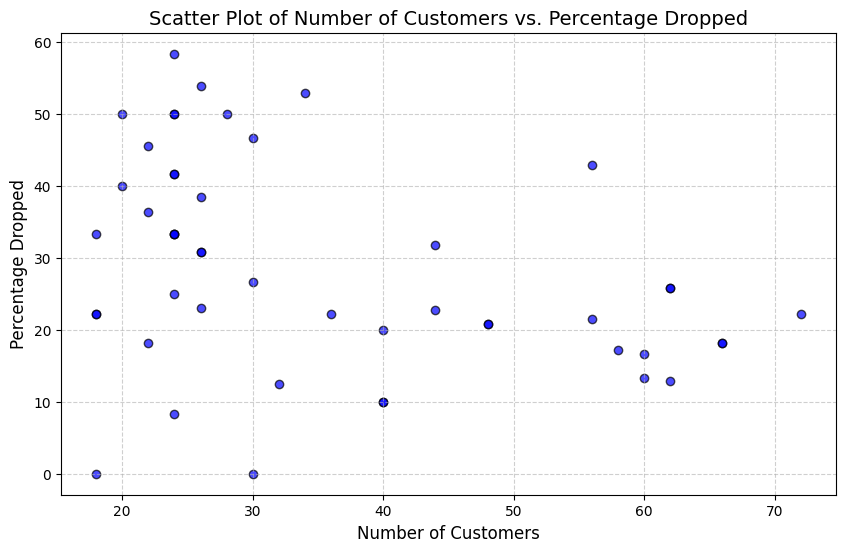

In [51]:

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(results30_6['num_customers'], results30_6['percentage_dropped'], color='b', alpha=0.7, edgecolor='k')

plt.title('Scatter Plot of Number of Customers vs. Percentage Dropped', fontsize=14)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Percentage Dropped', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Saving the plot to a file
# plt.savefig('/num_customers_vs_percentage_dropped.png', dpi=300, bbox_inches='tight')

plt.show()

In [52]:

# Calculating the correlation
correlation = results30_6['num_customers'].corr(results30_6['percentage_dropped'])
print(f"Correlation between Number of Customers and Percentage Dropped: {correlation:.2f}")

Correlation between Number of Customers and Percentage Dropped: -0.37


## Dropped Count for each location index

In [36]:
unique_location

,Index,Latitude,Longitude,Source
0,0,57.701050,11.813120,depot
1,1,57.718720,11.828570,velocity
2,2,57.741650,11.863580,velocity
3,3,56.290610,13.291850,velocity
4,4,55.549440,14.338520,velocity
...,...,...,...,...
340,340,60.658510,17.163370,station
341,341,58.389825,15.091080,station
342,342,57.874115,11.966324,station
343,343,58.352637,11.810593,station


In [37]:
# Combine all dropped lists into a single list
all_dropped_indices = sum(results30_6['dropped_index'], [])
# Count the occurrences of each number
dropped_counts = Counter(all_dropped_indices)
# Convert to DataFrame for easy plotting
dropped_counts_df = pd.DataFrame(list(dropped_counts.items()), columns=['Index', 'Count'])
# Merge with unique_location only once
dropped_merged_df = pd.merge(dropped_counts_df, unique_location, on='Index', how='left')
dropped_merged_df

,Index,Count,Latitude,Longitude,Source
0,30,8,57.71536,11.99014,velocity
1,5,119,57.70105,11.81312,velocity
2,9,4,57.68486,12.22925,velocity
3,63,1,57.73889,12.07875,velocity
4,195,1,59.61875,16.46171,velocity
...,...,...,...,...,...
69,184,2,59.47773,17.86000,velocity
70,181,1,59.06508,16.58935,velocity
71,61,1,57.69728,11.98906,velocity
72,197,1,59.57637,17.87496,velocity


In [61]:

def create_pickup_delivery_pairs(dropped_indices):
    pairs = []
    half_length = len(dropped_indices) // 2
    for i in range(half_length):
        pickup = dropped_indices[i]
        delivery = dropped_indices[i + half_length]
        pairs.append((pickup, delivery))
    return pairs

# Example usage:
# Apply function to the 'dropped_index' column and create a new column
results30_6['pickup_delivery_pairs_dropped'] = results30_6['dropped_index'].apply(create_pickup_delivery_pairs)
results30_6['pickup_delivery_pairs'] = results30_6['used_index'].apply(create_pickup_delivery_pairs)

In [62]:

# Combine all pairs into a single list
all_pairs = sum(results30_6['pickup_delivery_pairs'], [])

# Count the occurrences of each pair
pair_counts = Counter(all_pairs)

# Convert to DataFrame for easy plotting
pairs_counts_df = pd.DataFrame(list(pair_counts.items()), columns=['Pair', 'Count'])

# Split the pairs into separate columns for pickup and delivery
pairs_counts_df[['Pickup', 'Delivery']] = pd.DataFrame(pairs_counts_df['Pair'].tolist(), index=pairs_counts_df.index)

# Merge with unique_location for Pickup coordinates
pairs_counts_df = pairs_counts_df.merge(unique_location[['Index', 'Latitude', 'Longitude']],
                                      left_on='Pickup', right_on='Index', how='left').rename(
                                      columns={'Latitude': 'Pickup_Latitude', 'Longitude': 'Pickup_Longitude'})

# Merge with unique_location for Delivery coordinates
pairs_counts_df = pairs_counts_df.merge(unique_location[['Index', 'Latitude', 'Longitude']],
                                      left_on='Delivery', right_on='Index', how='left').rename(
                                      columns={'Latitude': 'Delivery_Latitude', 'Longitude': 'Delivery_Longitude'})

# Drop the extra 'Index' columns from the merge
pairs_counts_df.drop(columns=['Index_x', 'Index_y'], inplace=True)

# Create Pickup_Coordinate and Delivery_Coordinate columns
pairs_counts_df['Pickup_Coordinate'] = list(zip(pairs_counts_df['Pickup_Latitude'], pairs_counts_df['Pickup_Longitude']))
pairs_counts_df['Delivery_Coordinate'] = list(zip(pairs_counts_df['Delivery_Latitude'], pairs_counts_df['Delivery_Longitude']))
total_sum = 230
pairs_counts_df['Percentage'] = (pairs_counts_df['Count'] / total_sum) * 100
# Display the updated DataFrame with new columns
pairs_counts_df[['Pair', 'Count','Percentage', 'Pickup_Coordinate', 'Delivery_Coordinate']]

,Pair,Count,Percentage,Pickup_Coordinate,Delivery_Coordinate
0,"(5, 301)",2,0.869565,"(57.70105, 11.81312)","(59.26748556422831, 17.9026744818417)"
1,"(30, 213)",1,0.434783,"(57.71536, 11.99014)","(59.29716939447519, 15.205974101847232)"
2,"(334, 56)",1,0.434783,"(57.741689, 12.004364)","(57.77258, 11.89947)"
3,"(62, 302)",1,0.434783,"(59.56546, 17.551)","(58.31349705824971, 12.298161038962462)"
4,"(214, 180)",1,0.434783,"(59.8446576086142, 17.7277347442326)","(59.37207, 13.5313)"
...,...,...,...,...,...
508,"(23, 49)",1,0.434783,"(57.7001, 11.82755)","(57.7017, 11.82669)"
509,"(32, 226)",1,0.434783,"(57.69837, 11.85593)","(56.67243, 12.79762)"
510,"(30, 179)",1,0.434783,"(57.71536, 11.99014)","(56.04471, 12.77744)"
511,"(334, 49)",1,0.434783,"(57.741689, 12.004364)","(57.7017, 11.82669)"


In [ ]:

# Combine all pairs into a single list
all_pairs = sum(results30_6['pickup_delivery_pairs_used'], [])

# Count the occurrences of each pair
pair_counts = Counter(all_pairs)

# Convert to DataFrame for easy plotting
pair_dropped_counts_df = pd.DataFrame(list(pair_counts.items()), columns=['Pair', 'Count'])

# Split the pairs into separate columns for pickup and delivery
pair_dropped_counts_df[['Pickup', 'Delivery']] = pd.DataFrame(pair_dropped_counts_df['Pair'].tolist(), index=pair_dropped_counts_df.index)

# Merge with unique_location for Pickup coordinates
pair_dropped_counts_df = pair_dropped_counts_df.merge(unique_location[['Index', 'Latitude', 'Longitude']],
                                      left_on='Pickup', right_on='Index', how='left').rename(
                                      columns={'Latitude': 'Pickup_Latitude', 'Longitude': 'Pickup_Longitude'})

# Merge with unique_location for Delivery coordinates
pair_dropped_counts_df = pair_dropped_counts_df.merge(unique_location[['Index', 'Latitude', 'Longitude']],
                                      left_on='Delivery', right_on='Index', how='left').rename(
                                      columns={'Latitude': 'Delivery_Latitude', 'Longitude': 'Delivery_Longitude'})

# Drop the extra 'Index' columns from the merge
pair_dropped_counts_df.drop(columns=['Index_x', 'Index_y'], inplace=True)

# Create Pickup_Coordinate and Delivery_Coordinate columns
pair_dropped_counts_df['Pickup_Coordinate'] = list(zip(pair_dropped_counts_df['Pickup_Latitude'], pair_dropped_counts_df['Pickup_Longitude']))
pair_dropped_counts_df['Delivery_Coordinate'] = list(zip(pair_dropped_counts_df['Delivery_Latitude'], pair_dropped_counts_df['Delivery_Longitude']))
total_sum = 230
pair_dropped_counts_df['Percentage'] = (pair_dropped_counts_df['Count'] / total_sum) * 100
# Display the updated DataFrame with new columns
pair_dropped_counts_df[['Pair', 'Count','Percentage', 'Pickup_Coordinate', 'Delivery_Coordinate']]

In [56]:
import json

# Load the JSON file with the distance matrix
file_path = '../evrp/data/distance_matrix.json'

# Open and load the JSON file
with open(file_path, 'r') as file:
    distance_matrix = json.load(file)


# Function to get distance from the matrix
def get_distance_from_pair(pair):
    row, col = pair
    try:
        return distance_matrix[row][col]
    except IndexError:
        return None  # Handle out-of-bound cases if necessary

# Apply the function to get distances and add them to a new column
pair_dropped_counts_df['Distance'] = pair_dropped_counts_df['Pair'].apply(get_distance_from_pair)


In [57]:
pair_dropped_counts_df[['Pair', 'Count','Distance','Percentage', 'Pickup_Coordinate', 'Delivery_Coordinate']]


,Pair,Count,Distance,Percentage,Pickup_Coordinate,Delivery_Coordinate
0,"(30, 195)",1,372844.5,0.434783,"(57.71536, 11.99014)","(59.61875, 16.46171)"
1,"(30, 186)",1,462287.0,0.434783,"(57.71536, 11.99014)","(59.44582, 17.80602)"
2,"(5, 20)",35,488006.3,15.217391,"(57.70105, 11.81312)","(59.15118, 18.11912)"
3,"(5, 75)",65,449532.7,28.260870,"(57.70105, 11.81312)","(59.58049, 17.48884)"
4,"(9, 34)",3,301598.5,1.304348,"(57.68486, 12.22925)","(58.63452, 16.22524)"
5,"(63, 199)",1,253337.3,0.434783,"(57.73889, 12.07875)","(59.06209, 15.07005)"
6,"(10, 34)",11,369277.7,4.782609,"(58.12185, 12.13803)","(58.63452, 16.22524)"
7,"(10, 103)",5,357813.8,2.173913,"(58.12185, 12.13803)","(59.33927, 17.02979)"
8,"(10, 95)",10,363309.6,4.347826,"(58.12185, 12.13803)","(58.60807, 16.17815)"
9,"(27, 169)",1,289022.1,0.434783,"(57.83125, 13.0035)","(59.60213, 15.1939)"


In [66]:

# Apply the function to get distances and add them to a new column
pairs_counts_df['Distance'] = pairs_counts_df['Pair'].apply(get_distance_from_pair)
pairs_counts_df[pairs_counts_df['Distance']>0][['Pair', 'Count','Distance','Percentage', 'Pickup_Coordinate', 'Delivery_Coordinate']]


,Pair,Count,Distance,Percentage,Pickup_Coordinate,Delivery_Coordinate
0,"(5, 301)",2,468941.3,0.869565,"(57.70105, 11.81312)","(59.26748556422831, 17.9026744818417)"
1,"(30, 213)",1,284432.5,0.434783,"(57.71536, 11.99014)","(59.29716939447519, 15.205974101847232)"
2,"(334, 56)",1,12447.0,0.434783,"(57.741689, 12.004364)","(57.77258, 11.89947)"
3,"(62, 302)",1,378529.4,0.434783,"(59.56546, 17.551)","(58.31349705824971, 12.298161038962462)"
4,"(214, 180)",1,291060.8,0.434783,"(59.8446576086142, 17.7277347442326)","(59.37207, 13.5313)"
...,...,...,...,...,...,...
508,"(23, 49)",1,209.6,0.434783,"(57.7001, 11.82755)","(57.7017, 11.82669)"
509,"(32, 226)",1,148456.2,0.434783,"(57.69837, 11.85593)","(56.67243, 12.79762)"
510,"(30, 179)",1,213559.0,0.434783,"(57.71536, 11.99014)","(56.04471, 12.77744)"
511,"(334, 49)",1,14151.0,0.434783,"(57.741689, 12.004364)","(57.7017, 11.82669)"


In [ ]:
pair_dropped_counts_df['Count'].sum() / (pair_counts_df['Count'].sum() + pair_dropped_counts_df['Count'].sum())


In [ ]:
pair_counts_df[pair_counts_df['Pair'] ==(5,75)]

In [ ]:
import folium
from folium import Popup, Tooltip
stations_30=[
        251,
        245,
        302,
        214,
        274,
        317,
        265,
        226,
        262,
        329,
        278,
        328,
        253,
        268,
        298,
        324,
        242,
        287,
        334,
        225,
        257,
        301,
        254,
        240,
        213,
        337,
        327,
        244,
        264,
        313
    ]
# Initialize the base map centered around the average coordinates
average_lat = pair_dropped_counts_df[['Pickup_Latitude', 'Delivery_Latitude']].mean().mean()
average_lon = pair_dropped_counts_df[['Pickup_Longitude', 'Delivery_Longitude']].mean().mean()
m = folium.Map(location=[average_lat, average_lon], zoom_start=6)

# Uniform color for all lines
line_color = 'red'  # Set to any desired color

# Add pickup and delivery markers and lines connecting them
for _, row in pair_dropped_counts_df[pair_dropped_counts_df['Count'] > 6].sort_values(by="Count", ascending=True).iterrows():
    # Extract coordinates
    pickup_coords = (row['Pickup_Latitude'], row['Pickup_Longitude'])
    delivery_coords = (row['Delivery_Latitude'], row['Delivery_Longitude'])
    
    # Add pickup and delivery markers
    folium.Marker(pickup_coords, 
                  icon=folium.Icon(color='blue', icon='info-sign'),
                  popup=Popup(f"Pickup Point: {row['Pickup']}"),
                  tooltip=Tooltip(f"Pickup Point: {row['Pickup']}")).add_to(m)
    
    folium.Marker(delivery_coords, 
                  icon=folium.Icon(color='green', icon='info-sign'),
                  popup=Popup(f"Delivery Point: {row['Delivery']}"),
                  tooltip=Tooltip(f"Delivery Point: {row['Delivery']}")).add_to(m)
    
    # Add line connecting pickup and delivery points with uniform red color
    folium.PolyLine(locations=[pickup_coords, delivery_coords], color=line_color, weight=2).add_to(m)

# Display the map in Jupyter Notebook or save it as an HTML file
m.save('dropped_pickup_delivery_map.html')


In [ ]:
# Filter rows where '198' is in the 'used_index' list
results30[results30['dropped_index'].apply(lambda x: 67 in x)]


In [ ]:
def map_dropped_used_customers(results, unique_location=unique_location, output_path=None):

    # Combine all dropped lists into a single list
    all_dropped_indices = sum(results['dropped_index'], [])
    # Count the occurrences of each number
    dropped_counts = Counter(all_dropped_indices)
    # Convert to DataFrame for easy plotting
    dropped_counts_df = pd.DataFrame(list(dropped_counts.items()), columns=['Index', 'Count'])
    # Merge with unique_location only once
    dropped_merged_df = pd.merge(dropped_counts_df, unique_location, on='Index', how='left')
    
    # Combine all used lists into a single list
    all_used_indices = sum(results['used_index'], [])
    used_counts = Counter(all_used_indices)
    used_counts_df = pd.DataFrame(list(used_counts.items()), columns=['Index', 'Count'])
    used_merged_df = pd.merge(used_counts_df, unique_location, on='Index', how='left')
    
    # Create a base map centered around the mean latitude and longitude
    m = folium.Map(location=[dropped_merged_df['Latitude'].mean(), dropped_merged_df['Longitude'].mean()], zoom_start=6)
    
    # Add Circle Markers to the map
    for _, row in dropped_merged_df.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=max(row['Count'] / 10, 3),  # Adjust the radius based on count
            color=None,  # No border color
            fill=True,
            fill_color='red',  # Use a single color for the marker
            fill_opacity=0.7,  # Adjust opacity for better visualization
            popup=f"Index: {row['Index']}\nCount: {row['Count']}"
        ).add_to(m)
        
    # Add Circle Markers to the map
    for _, row in used_merged_df.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=max(row['Count'] / 10, 3),  # Adjust the radius based on count
            color=None,  # No border color
            fill=True,
            fill_color='blue',  # Use a single color for the marker
            fill_opacity=0.7,  # Adjust opacity for better visualization
            popup=f"Index: {row['Index']}\nCount: {row['Count']}"
        ).add_to(m)


    m.save(output_path)

In [ ]:
map_dropped_used_customers(results_all, unique_location, output_path = 'dropped_used_customer_map_all.html')
map_dropped_used_customers(results15, output_path = 'dropped_used_customer_map_15.html')
map_dropped_used_customers(results30, output_path = 'dropped_used_customer_map_30.html')
map_dropped_used_customers(results50, output_path = 'dropped_used_customer_map_50.html')
map_dropped_used_customers(results70, output_path = 'dropped_used_customer_map_70.html')


### Map different stations

In [ ]:
# Dropped and Used Together for a specific date
def show_stations_on_map(solution_data_path, unique_location_df=unique_location, map_filename=None):
    
    with open(solution_data_path, 'r') as f:
        solution_data = json.load(f)
    station_index = solution_data['station_index']
        
    # Create a base map centered around the mean latitude and longitude of the used and dropped indexes
    location_data = unique_location_df[unique_location_df['Index'].isin(station_index)]
    m = folium.Map(location=[location_data['Latitude'].mean(), location_data['Longitude'].mean()], zoom_start=6)
    
    # Add Circle Markers for Stations
    for _, row in unique_location_df[unique_location_df['Index'].isin(station_index)].iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,  # Fixed radius for visibility
            color=None,  # Color for used indexes
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=f"Index: {row['Index']}"
        ).add_to(m)

    if map_filename:
        m.save(map_filename)
    
    # print(f"Map saved to {map_filename}")
    return m



In [ ]:

# Load solution data from JSON file
solution_data_path = '../solutions/epdp_50stations/solution_epdp_2023-10-09.json'

m = show_stations_on_map(solution_data_path, map_filename='stations_map_50.html')
# m

In [ ]:
from config.config import EPDPConfig

In [ ]:
config = EPDPConfig()

In [ ]:
station_index = config.stations_to_use

# Create a base map centered around the mean latitude and longitude of the used and dropped indexes
location_data = unique_location[unique_location['Index'].isin(station_index)]
m = folium.Map(location=[location_data['Latitude'].mean(), location_data['Longitude'].mean()], zoom_start=6)

# Add Circle Markers for Stations
for _, row in unique_location[unique_location['Index'].isin(station_index)].iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,  # Fixed radius for visibility
        color=None,  # Color for used indexes
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Index: {row['Index']}"
    ).add_to(m)

m.save('stations_map_filtered.html')

## 2. Average Customer per route

In [68]:

# Define the base directory
base_dir = '../evrp/data/instances'
solution_dir = '../solutions'
# Regular expression pattern to extract date from folder name
date_pattern = re.compile(r'instance_(\d{4}-\d{2}-\d{2})')

# Initialize a list to store results
results = []

# Iterate over each directory in the base directory
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    match = date_pattern.match(folder_name)
    if match:
        date = match.group(1)
        
    # Construct the file paths
    solution_path = os.path.join(solution_dir, f'epdp_30stations6/solution_epdp_{date}.json')
    # solution_path = os.path.join(solution_dir, f'pdp/solution_pdp_{date}.json')
    # 
    # Read and parse the JSON files
    with open(solution_path, 'r') as file:
        solution_data = json.load(file)
        route = solution_data.get('routes')
        try:
            station_nodes = solution_data.get('station_nodes')
        except:
            station_nodes = []
        num_routes = sum(1 for key in route if route[key])
        cumul_vars = solution_data.get('cumul_vars')
        
        distances = []
        num_customers_per_route = []
        used_stations = []
        distance_etruck = []

        for route_key, route in route.items():
            if route:  # Check if the route is not empty
                last_node = str(route[-1])
                if last_node in cumul_vars:
                    last_distance = cumul_vars[last_node]["Distance"]
                    distances.append(last_distance)
                    if last_distance <= 300:
                        distance_etruck.append(route_key)
                route_only_customer = [item for item in route if item not in station_nodes]
                # route_only_customer = [item for item in route]
                num_customers_per_route.append(len(route_only_customer))
                
                route_used_stations = [item for item in route if item in station_nodes]
                # route_used_stations =[]
                used_stations.append(len(route_used_stations))
                
        avg_distance = sum(distances)/num_routes
        avg_num_customers = sum(num_customers_per_route) / num_routes
        avg_num_used_stations = sum(used_stations) / num_routes
    results.append({'date': date, 'num_routes': num_routes, 'avg_distance': avg_distance, 'avg_customers_per_route':avg_num_customers, 'avg_used_stations': avg_num_used_stations, 'total_used_stations':sum(used_stations),'etruck_available': distance_etruck})
    

JSONDecodeError: Expecting value: line 3092 column 5 (char 74432)

In [ ]:
pdp_results = pd.DataFrame(results)

# Merge demand category information with results
pdp_results['date'] = pd.to_datetime(pdp_results['date'])
pdp_results = pdp_results.merge(bookings_per_day[['StartRequestedDate', 'DemandCategory']], left_on='date', right_on='StartRequestedDate',how='left')

pdp_results

In [ ]:
epdp_results30 = pd.DataFrame(results)

# Merge demand category information with results
epdp_results30['date'] = pd.to_datetime(epdp_results30['date'])
epdp_results30 = epdp_results30.merge(bookings_per_day[['StartRequestedDate', 'DemandCategory']], left_on='date', right_on='StartRequestedDate',how='left')

epdp_results30

In [ ]:
epdp_results.groupby('DemandCategory').mean()

In [ ]:
epdp_results30.groupby('DemandCategory').mean()

In [ ]:
pdp_results.groupby('DemandCategory').mean()

In [ ]:
print(pdp_results['avg_customers_per_route'].mean())
print(epdp_results['avg_customers_per_route'].mean())
print(epdp_results30['avg_customers_per_route'].mean())

## 3. Fuel Cost vs Electricity Cost

In [ ]:
def calculate_cost_proportion(x, y):
    # x: diesel truck distance
    # y: electric truck distance
    return (y * 3.48) / (x * 13.06)

In [ ]:
with open('../solutions/epdp/solution_epdp_2023-04-21.json', 'r') as file:
    solution_data = json.load(file)
    solution_final_objective = solution_data.get('final_objective')

## 4. CO2 Emission

In [ ]:
def calculate_co2_proportion(x,y):
    return (y*0.37) / x